# Advanced Lane Lines
## Udacity Self-Driving Car Engineer Program
#### Josh Smith
##### 20170220

## Camera Calibration
Using a known calibration target measure and correct image distortion due to various lense effects

### Process Calibration Images

In [217]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [24]:
chessboard = (9, 6)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((np.product(chessboard),3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard[0], 0:chessboard[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

good_cal_images = 0

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    print("Processing image %i\t" % (idx+1), end='')
    img = cv2.imread(fname)
    print("  Image imported", end='')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print("  Converted to grayscale", end='')

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard, None)
    
    # If found, add object points, image points
    if ret == True:
        good_cal_images += 1
        print("  Corners found!")
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, chessboard, corners, ret)
        # save fancy calibration image?
        if True:
            write_name = 'camera_cal/corners_found/calibrated'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    else:
        print("  No corners found :(")
print('%i good calibaration images out of %i total.' % (good_cal_images, len(images)))
cv2.destroyAllWindows()

Processing image 1	  Image imported  Converted to grayscale  No corners found :(
Processing image 2	  Image imported  Converted to grayscale  Corners found!
Processing image 3	  Image imported  Converted to grayscale  Corners found!
Processing image 4	  Image imported  Converted to grayscale  Corners found!
Processing image 5	  Image imported  Converted to grayscale  Corners found!
Processing image 6	  Image imported  Converted to grayscale  Corners found!
Processing image 7	  Image imported  Converted to grayscale  Corners found!
Processing image 8	  Image imported  Converted to grayscale  Corners found!
Processing image 9	  Image imported  Converted to grayscale  Corners found!
Processing image 10	  Image imported  Converted to grayscale  Corners found!
Processing image 11	  Image imported  Converted to grayscale  Corners found!
Processing image 12	  Image imported  Converted to grayscale  Corners found!
Processing image 13	  Image imported  Converted to grayscale  Corners found!
Pro

### Run Calibration
Run camera calibration to determine calibration parameters.

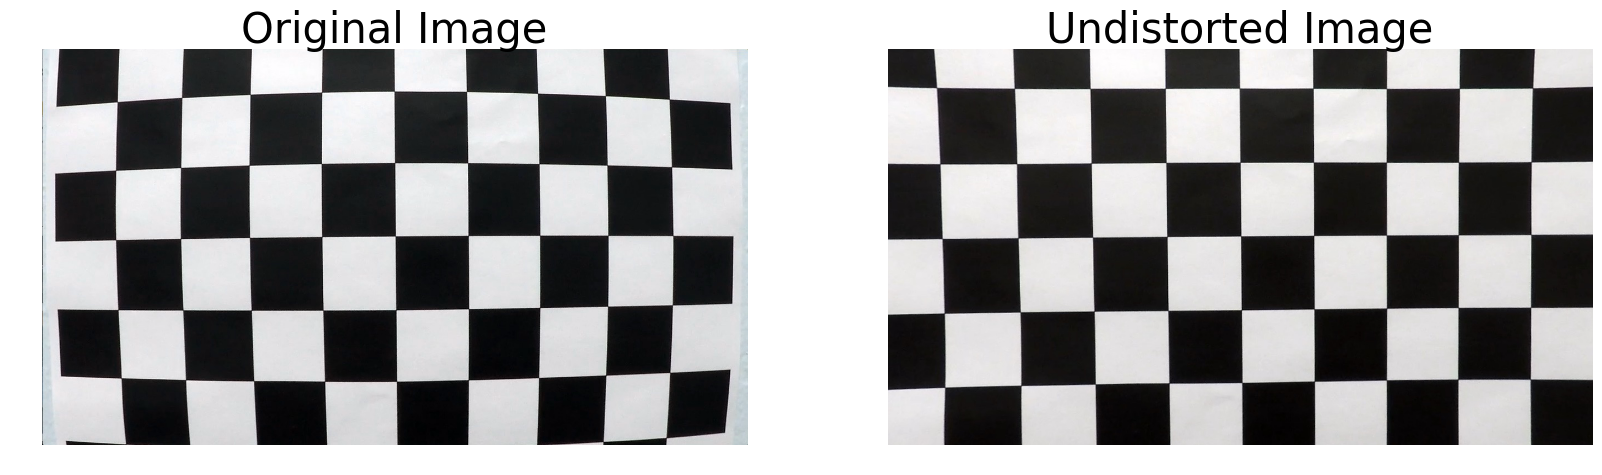

In [26]:
import pickle
%matplotlib inline

# Test undistortion on an image
image = cv2.imread('camera_cal/calibration1.jpg')
image_size = (image.shape[1], image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size,None,None)

# Undistort image
dst = cv2.undistort(image, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibrated/distorted.jpg',img)
cv2.imwrite('camera_cal/calibrated/undistorted.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
calibration_pickle = {}
calibration_pickle["mtx"] = mtx
calibration_pickle["dist"] = dist
pickle.dump( calibration_pickle, open("camera_cal/camera_calibration.p", "wb"))
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis('off')
plt.show()
fig.savefig('output_images/camera_calibration.jpg', dpi=fig.dpi)

## Image Processing Pipeline

### Undistort Image

In [32]:
def undistort(image, calibration):
    """ Correct for camera distortion
    image -- image to undistort
    calibration -- dictionary containing mtx and dist calibration values
    returns -- undistorted image
    """
    mtx = calibration['mtx']
    dist = calibration['dist']
    return cv2.undistort(image, mtx, dist, None, mtx)

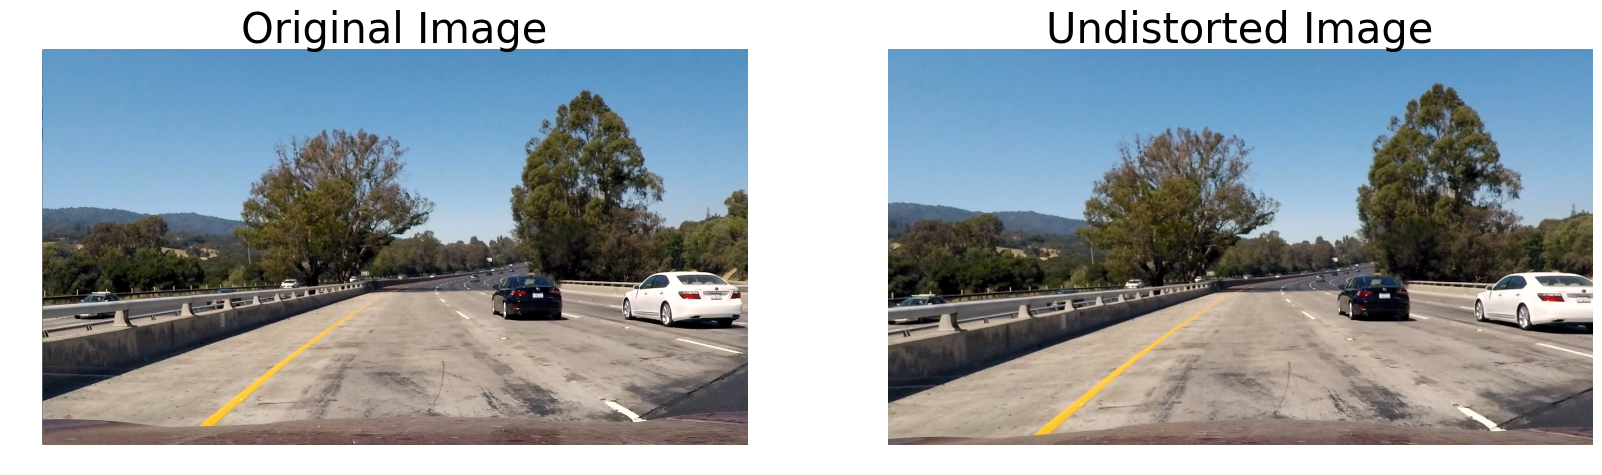

In [33]:
file = 'test_images/test1.jpg'
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
camera_calibration = pickle.load(open('camera_cal/camera_calibration.p', 'rb'))
undistorted_image = undistort(image, camera_calibration)

# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis('off')
plt.show()
fig.savefig('output_images/undistort.jpg', dpi=fig.dpi)

### Scrub Image to Binary

### Transform to Birds Eye View

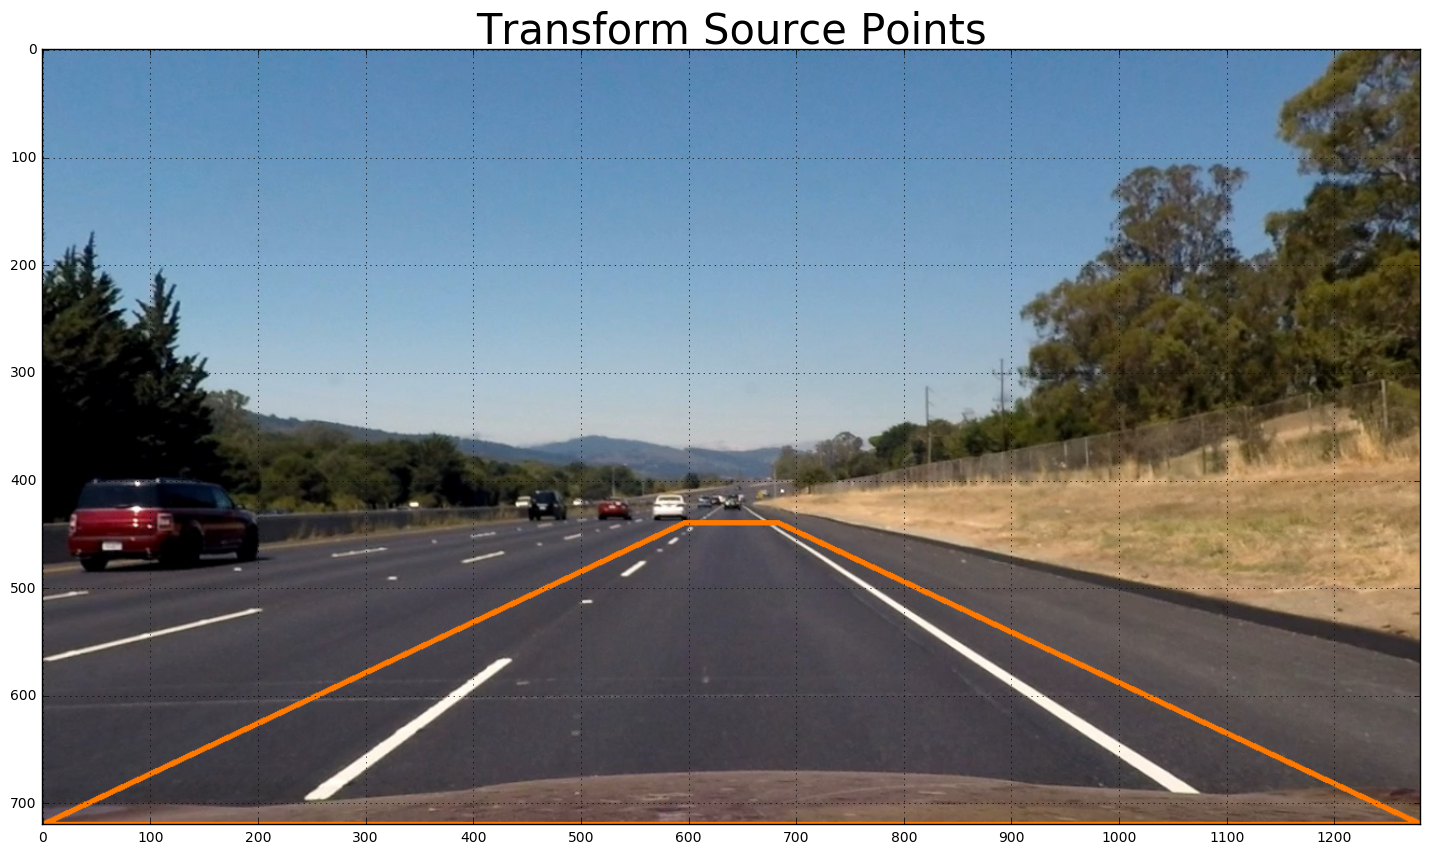

In [280]:
color = {}
color["perspective"] = (255, 121, 1)

# Load image for perspective testing
image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_size = (image.shape[1], image.shape[0])

# Undistort image
undistorted_image = undistort(image, camera_calibration)

# Determine and draw source points for transform
center = image_size[0]//2
# near_width = 870
# far_width = 58
near_width = image_size[0]
far_width = 95

skew = 3

vanishing_point=(image_size[0]/2-17, 413)
far_dist = 440
far_left = vanishing_point[0] - skew - vanishing_point[0]*(vanishing_point[1]-far_dist)/(image_size[1]-far_dist)
far_right = vanishing_point[0] + skew + (image_size[0]-vanishing_point[0])*(vanishing_point[1]-far_dist)/(image_size[0]-vanishing_point[0])

# lane overlay method
# src = np.array([[center-near_width//2,image_size[1]],
#                 [center+near_width//2,image_size[1]],
#                 [center+far_width//2+skew,image_size[1]-far_dist],
#                 [center-far_width//2,image_size[1]-far_dist]], np.float32)

# vanishing point method
src = np.array([[0, image_size[1]],
                [image_size[0], image_size[1]],
                [far_left, far_dist],
                [far_right, far_dist]], np.float32)

dst = np.array([[center-width//2, image_size[1]],
                [center+width//2, image_size[1]],
                [center+width//2, image_size[1]-far_dist],
                [center-width//2, image_size[1]-far_dist]], np.float32)

src_draw = src.reshape((-1,1,2)).astype(int)
cv2.polylines(undistorted_image, [src_draw], True,color["perspective"], thickness=3)

fig = plt.figure(figsize=(20,10))
plt.imshow(undistorted_image)
plt.grid(True)
plt.xticks(np.arange(0, 1300, 100.0))
plt.yticks(np.arange(0, 800, 100.0))
plt.title('Transform Source Points', fontsize=30)
plt.show()

Source Points
[[    0.           720.        ]
 [ 1280.           720.        ]
 [  683.07501221   440.        ]
 [  596.           440.        ]] 

Desitnation Points
[[ 297.  720.]
 [ 983.  720.]
 [ 983.    0.]
 [ 297.    0.]] 

Transform Matrix
[[ -3.83771630e-01  -1.52476641e+00   8.85157435e+02]
 [ -6.93889390e-15  -1.84133660e+00   8.10188104e+02]
 [ -1.05167611e-17  -2.38343798e-03   1.00000000e+00]] 

Inverse Transform Matrix
[[  1.26931505e-01  -8.27777778e-01   5.58301343e+02]
 [ -3.77475828e-15  -5.43083758e-01   4.40000000e+02]
 [ -7.37257477e-18  -1.29440645e-03   1.00000000e+00]]


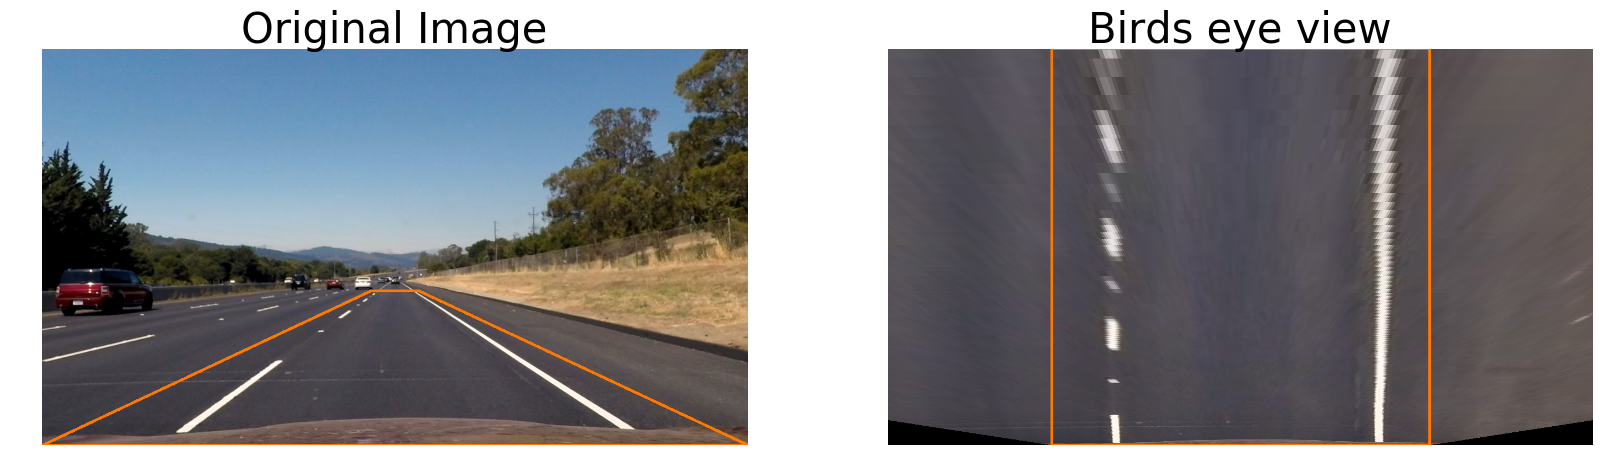

In [281]:
# Determine transform source and destination points
center = image_size[0]//2
far_dist = image_size[1]
width = (near_width + far_width)//2

print("Source Points")
print(src, "\n")
print("Desitnation Points")
print(dst, "\n")

# Undistort image
undistorted_image = undistort(image, camera_calibration)

# Transform image
M = cv2.getPerspectiveTransform(src,dst)
M_inv = cv2.getPerspectiveTransform(dst,src)
print("Transform Matrix")
print(M, "\n")
print("Inverse Transform Matrix")
print(M_inv)
warped = cv2.warpPerspective(undistorted_image, M, image_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

# Draw bird's eye view lines
dst_draw = dst.reshape((-1,1,2)).astype(int)
cv2.polylines(warped, [dst_draw], True,color["perspective"], thickness=3)

# Draw driver perspective lines
cv2.polylines(undistorted_image, [src_draw], True, color["perspective"], thickness=3)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
trasform_pickle = {}
trasform_pickle["driver2bird"] = M
trasform_pickle["bird2driver"] = M_inv
pickle.dump(trasform_pickle, open( "transform.p", "wb"))
# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_image)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(warped)
ax2.set_title('Birds eye view', fontsize=30)
ax2.axis('off')
plt.show()
# fig.savefig('output_images/birds_eye.jpg', dpi=fig.dpi)

In [209]:
M = None
def transform(image, M):
    """ Transform to image using the predetermined transform matrix M
    image -- road view image
    M -- transform matrix, use the transform.p file and either driver2bird or bird2driver
    return -- transformed image
    """
    image_size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

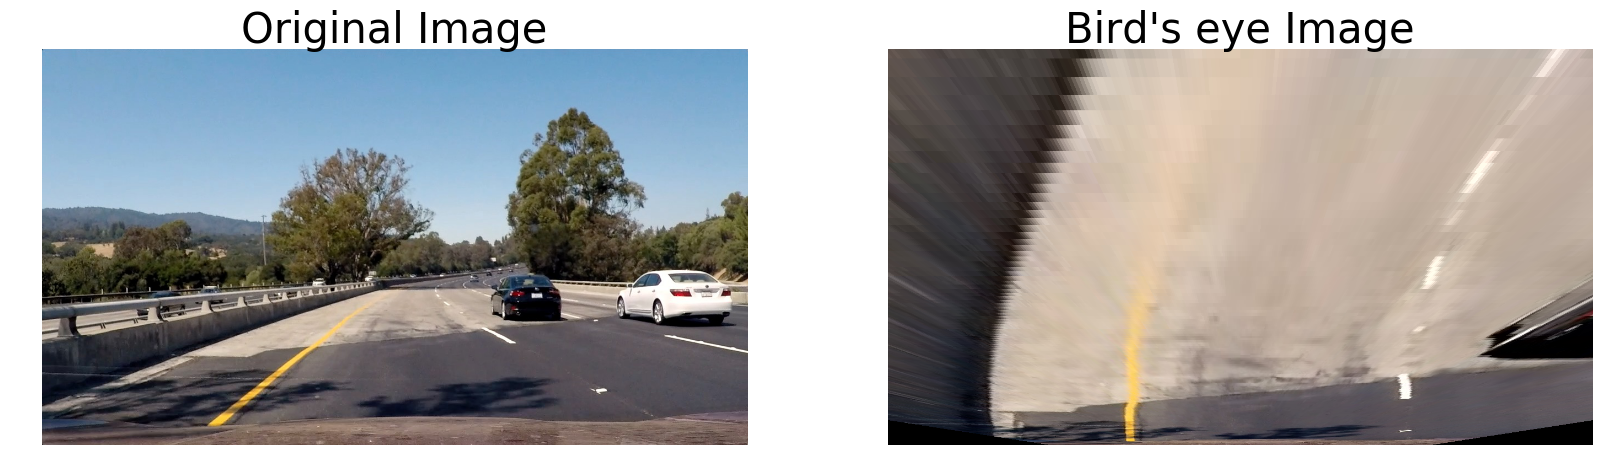

In [286]:
file = 'test_images/test4.jpg'
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transform_matrix = pickle.load(open('transform.p', 'rb'))
birds_eye_image = transform(image, transform_matrix["driver2bird"])

# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(birds_eye_image)
ax2.set_title('Bird\'s eye Image', fontsize=30)
ax2.axis('off')
plt.show()
fig.savefig('output_images/birds_eye.jpg', dpi=fig.dpi)

### Identify Lane Markers and Fit Polynomial

### Calculate Radius of Curvature of the Lane and Position of Vehicle

### Project Lane on Original Image

## Video Processing

In [99]:
src = np.array([[50,50],[450,450],[70,420],[420,70]],np.float32)
dst = np.array([[0,0],[299,299],[0,299],[299,0]],np.float32)

ret = cv2.getPerspectiveTransform(src,dst)
print (ret)

[[  8.36097696e-01  -4.51944700e-02  -3.95451613e+01]
 [ -4.51944700e-02   8.36097696e-01  -3.95451613e+01]
 [  6.45161290e-05   6.45161290e-05   1.00000000e+00]]
